## Autoencoder for Earthquake triggered ground motion using fourier spectral amplitudes

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math

### read and prepare data

In [2]:
data_all = pd.read_csv('ESM_flatfile_FAS.csv',sep = ';', low_memory=False)

Select the columns with Fourier spectral amplitudes and convert to log10-scale. 
Reduce the two horizontal components to their geometric mean (on log10-scale??). 

In [3]:
## select columns with fourier spectral amplitude values
FAS_U_labels = [x for x in data_all.columns if 'U_F' in x]
FAS_V_labels = [x for x in data_all.columns if 'V_F' in x]
FAS_W_labels = [x for x in data_all.columns if 'W_F' in x]
data_3comp   = np.asarray(data_all[FAS_U_labels + FAS_V_labels + FAS_W_labels])

## extract the values of considered frequencies
frequencies  = [float(x[3:].replace("_", ".")) for x in FAS_U_labels]
n_freq       = len(frequencies)

## remove rows with nan values
nan_rows     = list(set(np.where(np.isnan(data_3comp))[0]))
data_3comp   = np.delete(data_3comp, nan_rows, 0)

## add small value to avoid log(0)
eps          = 10**(-8)
data_3comp  += eps

## take log10
data_3comp   = np.log10(data_3comp)

## reduce horizontal components to the geometric mean (arithmetic mean on log-scale)????
data_h = (data_3comp[:, :n_freq] + data_3comp[:, n_freq:(2*n_freq)])/2

## data set with horizontal (geom. mean) and vertical component of log FAS
data = np.concatenate((data_h, data_3comp[:, (2*n_freq):(3*n_freq)]), axis=1)

print("Data set dimension:", data.shape)

Data set dimension: (22643, 206)


#### Define training and test data.
The test and validation set include each about 1/10 of all data. The remaining data are used for training.
The training data are shuffled to avoid mini-batches that include several records from the same earthquake.  

In [21]:
batch_size = 128

n_data     = data.shape[0]
n_train    = math.ceil(n_data*8/10/batch_size)*batch_size
n_test     = math.ceil((n_data - n_train)/2)
n_val      = n_data - n_train - n_test

eps = 10**(-8)
data_train = data[ :n_train]
data_test  = data[n_train:(n_train+n_test)]
data_val   = data[(n_train+n_test):]

## shuffle ground motion records in the training data to destroy order
np.random.shuffle(data_train)
print("Number of training records:", data_train.shape[0])

Number of training records: 18176


Plot frequency spectrum for 10 records for data visualization and to control data preparation.

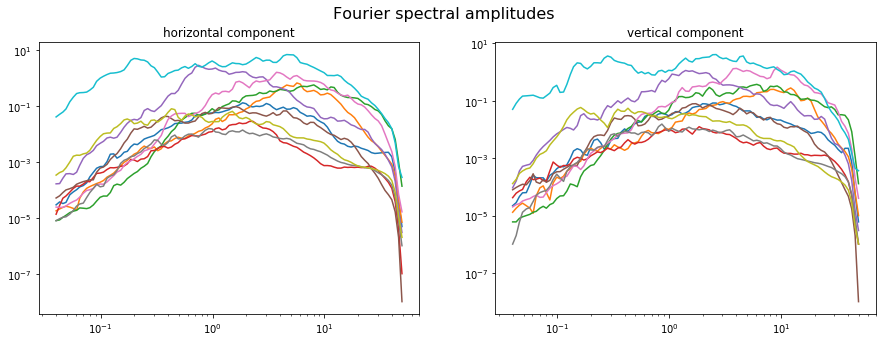

In [22]:
fig = plt.figure(1, figsize=(15, 5))
fig.suptitle("Fourier spectral amplitudes", fontsize = 16)
for i in range(10):
  plt.subplot(121)
  plt.loglog(frequencies, np.power(10, data_train[i,:n_freq]))
  plt.title("horizontal component")

  plt.subplot(122)
  plt.loglog(frequencies, np.power(10, data_train[i,n_freq:]))
  plt.title("vertical component")

plt.show()

### Construct Autoencoder

#### Stacked Autoencoder with L2 regularization
We construct an autoencoder by iteratively increasing the depth and decreasing the number of nodes in the bottleneck.
In phase 1 we start with an autoencoder with one hidden layer that still includes a relative large number of nodes.
In each subsequent phase we nest in an additional layer of smaller size and thus decrease the dimension of the manifold on which the input data are mapped to. 
We use a decoder that is symmetric to the endocer. Thus, for each layer we add in the encoder, we add a layer of same size to the decoder.

In [15]:
## Define number and size of hidden layers
n_inputs  = data_train.shape[1]
n_outputs = n_inputs
n_hidden1 = 64
n_hidden2 = 16  
n_hidden3 = 4
n_hidden4 = 2 
n_hidden3o = n_hidden3
n_hidden2o = n_hidden2
n_hidden1o = n_hidden1

## Define training settings
learning_rate = 0.01
l2_reg = 0.001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

########################
## Construct Autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

## define weight matrices
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_hidden4])
weights4o_init = initializer([n_hidden4, n_hidden3o])
weights3o_init = initializer([n_hidden3o, n_hidden2o])
weights2o_init = initializer([n_hidden2o, n_hidden1o])
weights1o_init = initializer([n_hidden1o, n_outputs])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1in")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2in")
weights3 = tf.Variable(weights3_init, dtype = tf.float32, name = "weights3in")
weights4 = tf.Variable(weights4_init, dtype = tf.float32, name = "weights4in")
weights4o = tf.Variable(weights4o_init, dtype = tf.float32, name = "weights4out")
weights3o = tf.Variable(weights3o_init, dtype = tf.float32, name = "weights3out")
weights2o = tf.Variable(weights2o_init, dtype = tf.float32, name = "weights2out")
weights1o = tf.Variable(weights1o_init, dtype = tf.float32, name = "weights1out")

## define biases
bias1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1in")
bias2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2in")
bias3 = tf.Variable(tf.zeros(n_hidden3), name = "biases3in")
bias4 = tf.Variable(tf.zeros(n_hidden4), name = "biases4in")
bias4o = tf.Variable(tf.zeros(n_hidden3o), name = "biases4out")
bias3o = tf.Variable(tf.zeros(n_hidden2o), name = "biases3out")
bias2o = tf.Variable(tf.zeros(n_hidden1o), name = "biases2out")
bias1o = tf.Variable(tf.zeros(n_outputs), name = "biases1out")

## define (hidden) layers
hidden1 = activation(tf.matmul(inputs,    weights1) + bias1)
hidden2 = activation(tf.matmul(hidden1,   weights2) + bias2)
hidden3 = activation(tf.matmul(hidden2,   weights3) + bias3)
hidden4 = activation(tf.matmul(hidden3,   weights4) + bias4)
hidden3o = activation(tf.matmul(hidden4,  weights4o) + bias4o)
hidden2o = activation(tf.matmul(hidden3o, weights3o) + bias3o)
hidden1o = activation(tf.matmul(hidden2o, weights2o) + bias2o)
outputs  = tf.matmul(hidden1o, weights1o) + bias1o

reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate)
#training_op = optimizer.minimize(loss)

# encoding form input to hidden1 and decode to output
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights1o) + bias1o
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - inputs)) # MSE
    phase1_reg_loss = regularizer(weights1) + regularizer(weights1o)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

# extend autoencoder to 3 hidden layers    
# encoding from input to hidden1 to hidden2 and decode via hidden1o to output
with tf.name_scope("phase2"):
    phase2_hidden1o = activation(tf.matmul(hidden2, weights2o) + bias2o)
    phase2_outputs = tf.matmul(phase2_hidden1o, weights1o) + bias1o 
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(phase2_outputs - inputs)) # MSE
    phase2_reg_loss = phase1_reg_loss + regularizer(weights2) + regularizer(weights2o)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    phase2_training_op = optimizer.minimize(phase2_loss)      
    
# extend autoencoder to 5 hidden layers    
# encoding from input to hidden1 to hidden2 to hidden3
with tf.name_scope("phase3"):
    phase3_hidden2o = activation(tf.matmul(hidden3, weights3o) + bias3o)
    phase3_hidden1o = activation(tf.matmul(phase3_hidden2o, weights2o) + bias2o)
    phase3_outputs = tf.matmul(phase3_hidden1o, weights1o) + bias1o 
    phase3_reconstruction_loss = tf.reduce_mean(tf.square(phase3_outputs - inputs)) # MSE
    phase3_reg_loss = phase2_reg_loss + regularizer(weights3) + regularizer(weights3o)
    phase3_loss = phase3_reconstruction_loss + phase3_reg_loss
    phase3_training_op = optimizer.minimize(phase3_loss)  
    
# extend autoencoder to 7 hidden layers    
# encoding from input to hidden1 to hidden2 to hidden3 to hidden4
with tf.name_scope("phase4"):
    phase4_hidden3o = activation(tf.matmul(hidden4, weights4o) + bias4o)
    phase4_hidden2o = activation(tf.matmul(phase4_hidden3o, weights3o) + bias3o)
    phase4_hidden1o = activation(tf.matmul(phase4_hidden2o, weights2o) + bias2o)
    phase4_outputs = tf.matmul(phase4_hidden1o, weights1o) + bias1o 
    phase4_reconstruction_loss = tf.reduce_mean(tf.square(phase4_outputs - inputs)) # MSE
    phase4_reg_loss = phase3_reg_loss + regularizer(weights4) + regularizer(weights4o)
    phase4_loss = phase4_reconstruction_loss + phase4_reg_loss
    phase4_training_op = optimizer.minimize(phase4_loss)  

init = tf.global_variables_initializer()

In [24]:
########################
## Train the autoencoder

with tf.Session() as sess:
    init.run()
    data_shuffle = data_train
    cur_pos = 0 # used to iterate over batches
    print("Phase1")
    for i in range(1001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase1_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 100 == 0:
            train_loss = phase1_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase1_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase1_out_values = phase1_outputs.eval(feed_dict = {inputs: data_test})
    
    print("Phase2")
    for i in range(1001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase2_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 100 == 0:
            train_loss = phase2_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase2_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase2_out_values = phase2_outputs.eval(feed_dict = {inputs: data_test})
    
    print("Phase3")
    for i in range(1001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase3_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 100 == 0:
            train_loss = phase3_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase3_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase3_out_values = phase3_outputs.eval(feed_dict = {inputs: data_test})
    
    print("Phase4")
    for i in range(1001):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
        sess.run(phase4_training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 100 == 0:
            train_loss = phase4_reconstruction_loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = phase4_reconstruction_loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    phase4_out_values = phase4_outputs.eval(feed_dict = {inputs: data_test})    

Phase1
step 0: training loss = 13.2226, test loss: 8.54716
step 100: training loss = 0.121208, test loss: 0.110284
step 200: training loss = 0.0689524, test loss: 0.0755206
step 300: training loss = 0.0579691, test loss: 0.0567143
step 400: training loss = 0.0404963, test loss: 0.0452745
step 500: training loss = 0.0333103, test loss: 0.0387213
step 600: training loss = 0.0286997, test loss: 0.0345048
step 700: training loss = 0.02762, test loss: 0.031725
step 800: training loss = 0.0258488, test loss: 0.0280663
step 900: training loss = 0.0237565, test loss: 0.0257782
step 1000: training loss = 0.0225262, test loss: 0.0247104
Phase2
step 0: training loss = 1.59956, test loss: 1.38843
step 100: training loss = 0.46078, test loss: 0.54692
step 200: training loss = 0.251467, test loss: 0.439284
step 300: training loss = 0.283497, test loss: 0.396883
step 400: training loss = 0.251635, test loss: 0.455301
step 500: training loss = 0.276998, test loss: 0.408114
step 600: training loss = 0.

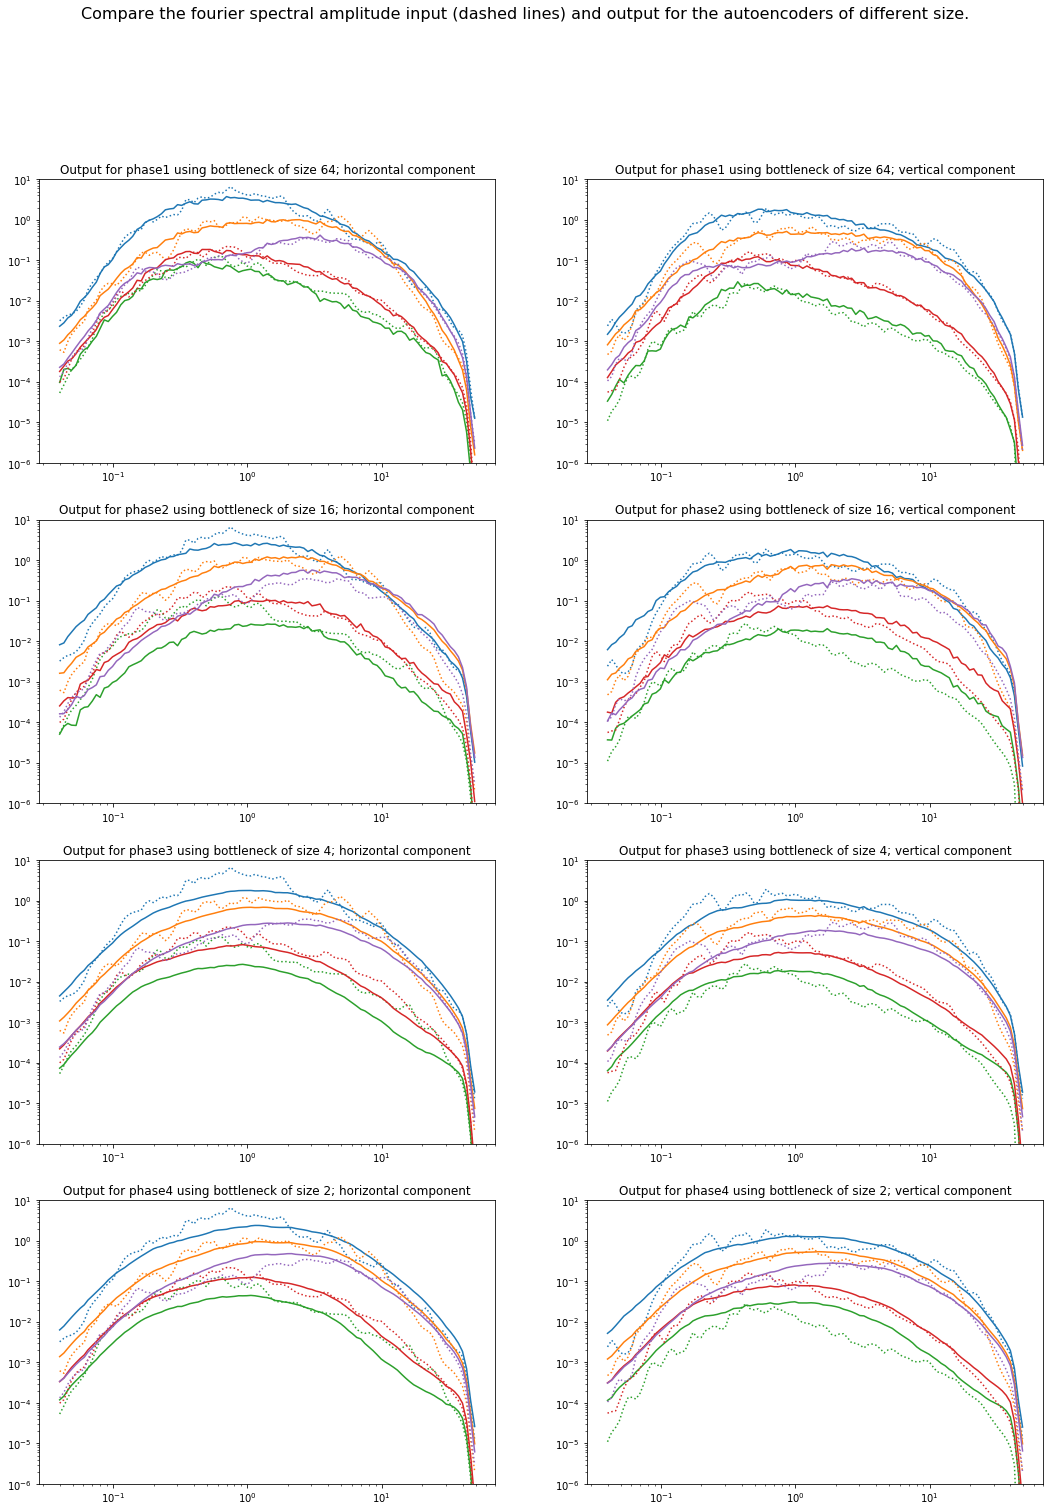

In [25]:
import matplotlib.colors as mcolors
fig = plt.figure(1, figsize=(18, 24))
fig.suptitle("Compare the fourier spectral amplitude input (dashed lines) and output for the autoencoders of different size.", fontsize = 16)
ylim = [10**(-6), 10]
for i in range(5):
  plt.subplot(421)
  plt.loglog(frequencies, np.power(10, phase1_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; horizontal component" % n_hidden1)
  plt.ylim(ylim)

  plt.subplot(422)
  plt.loglog(frequencies, np.power(10, phase1_out_values[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase1 using bottleneck of size %d; vertical component" % n_hidden1)
  plt.ylim(ylim)

  plt.subplot(423)
  plt.loglog(frequencies, np.power(10, phase2_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase2 using bottleneck of size %d; horizontal component" % n_hidden2)
  plt.ylim(ylim)

  plt.subplot(424)
  plt.loglog(frequencies, np.power(10, phase2_out_values[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase2 using bottleneck of size %d; vertical component" % n_hidden2)
  plt.ylim(ylim)  

  plt.subplot(425)
  plt.loglog(frequencies, np.power(10, phase3_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase3 using bottleneck of size %d; horizontal component" % n_hidden3)
  plt.ylim(ylim)

  plt.subplot(426)
  plt.loglog(frequencies, np.power(10, phase3_out_values[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase3 using bottleneck of size %d; vertical component" % n_hidden3)
  plt.ylim(ylim)  
  
  plt.subplot(427)
  plt.loglog(frequencies, np.power(10, phase4_out_values[i,:n_freq]))
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase4 using bottleneck of size %d; horizontal component" % n_hidden4)
  plt.ylim(ylim)

  plt.subplot(428)
  plt.loglog(frequencies, np.power(10, phase4_out_values[i,n_freq:]))
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]), linestyle = ":", 
             color = list(mcolors.TABLEAU_COLORS.values())[i])
  plt.title("Output for phase4 using bottleneck of size %d; vertical component" % n_hidden4)
  plt.ylim(ylim)    
plt.show()